In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

Using TensorFlow backend.


In [126]:
n_nodes = 10
n_dofs = n_nodes*2
n_elements = n_nodes-1
x = np.linspace(0, 1, n_nodes)

In [127]:
L = 1000 #mm
rho = 0.006 #kg/mm
E = 210000 #N/mm2
I = 0.801*10**6 #mm4
A = 764 #mm^2

In [128]:
#Element stiffnes matrix
L = L/n_elements
k = np.matrix([[12, -6*L, -12, -6*L], [-6*L, 4*L**2, 6*L, 2*L**2], [-12, 6*L, 12, 6*L], [-6*L, 2*L**2, 6*L, 4*L**2]])*E*I/L**3

#Element mass matrix
m = np.matrix([[156, 22*L, 54, -13*L],[22*L, 4*L**2, 13*L, -3*L**2], [54, 13*L, 156, -22*L], [-13*L, -3*L**2, -22*L, 4*L**2]] )*rho*A*L/420

In [129]:
#Global stiffness matrix
n_dofs = n_nodes*2
K = np.zeros([n_dofs, n_dofs])
for i in range(n_elements):
    K[2*i:2*i+4,2*i:2*i+4] += k
    
#Global mass matrix
M = np.zeros([n_dofs, n_dofs])
for i in range(n_elements):
    M[2*i:2*i+4,2*i:2*i+4] += m
    

In [130]:
#Force vector
F = np.zeros(n_dofs) 
F[-2] = 10000 

In [131]:
#Initial conditions
dz0 = np.zeros(n_nodes)
dzt0 = np.zeros(n_nodes)

d0 = np.zeros(n_dofs)
dt0 = np.zeros(n_dofs)
d0[0:-1:2] = dz0

In [132]:
#Account for homogenous BC
F = F[2:]
K = K[2:,2:]
M = M[2:,2:]

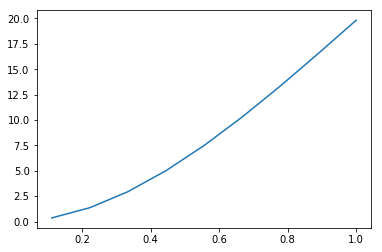

In [219]:
#Static solution

F[-2] = 10000

d = np.matmul(inv(K),F) 

plt.plot(x[1:],d[0::2])

In [134]:
from numpy.linalg import inv
import random

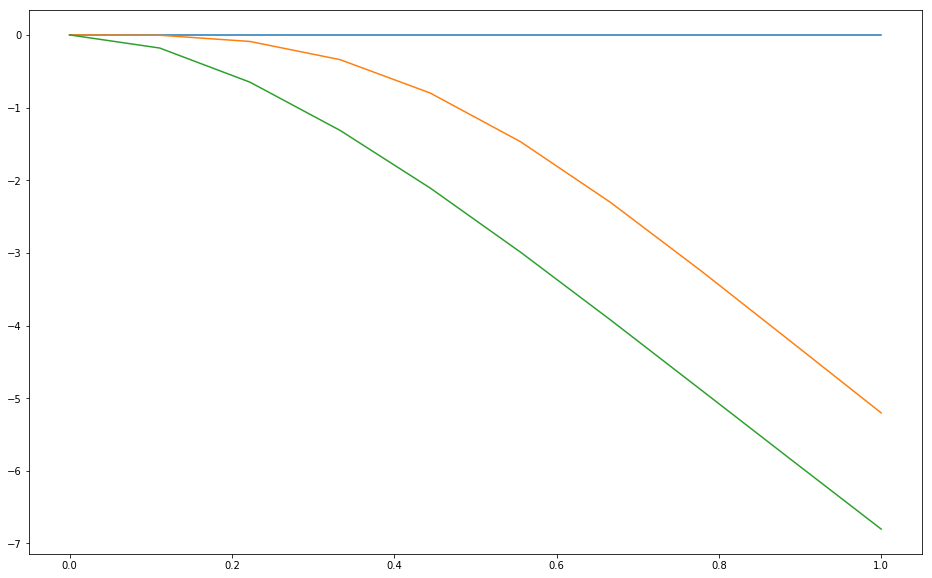

In [272]:
#Timestepping Theta Scheme
Theta = 1/2
d_old = d0[2:]
dt_old = d0[2:]
n_timesteps = 300
#D = np.zeros([n_nodes, n_timesteps])
#D[:,0] = dz0

dt = 1/10

Minv = inv(M)
MinvK = np.matmul(Minv, K)
Q = inv(M + (Theta*dt)**2*K)
P = (M - dt**2*Theta*(1-Theta)*K)
F = np.zeros(n_dofs) 
F = F[2:]
F_new = F

r_end = []
rt_end = []
f = []

plt.figure(figsize=(16,10))

for i in range(n_timesteps):
    
    #dt_i = -np.matmul(Minv, np.matmul(K,d_i)-F)
    #fi = np.random.random()*np.sin(i*dt)
    fi = 10000*np.sin(i*dt*2*np.pi)+10000*np.sin(i*dt*2*np.pi/20)
    f.append(fi)
    
    F_old = F_new
    F_new[-2] = fi
    
    
    d_new = np.matmul(Q, np.matmul(P, d_old)) + dt*np.matmul(Q, np.matmul(M,dt_old)) + dt**2*np.matmul(Q, (Theta**2*F_new + Theta*(1-Theta)*F_old))
    
    dt_new = dt_old - dt*np.matmul(MinvK, (Theta*d_new + (1-Theta)*d_old)) + dt*np.matmul(Minv, (Theta*F_new+(1-Theta)*F_old))
    
    dz = d_new[0:-1:2]
    dz = np.insert(dz,0,0)
    #dz = np.append(dz,0)
    
    r_end.append(dz[-1])
    rt_end.append(dt_new[-2])
    
    d_old = d_new
    dt_old = dt_new
    
    if i%100 == 0:
        plt.plot(x, dz)
    
plt.show()

In [273]:
len(rt_end)

300

In [274]:
len(r_end)

300

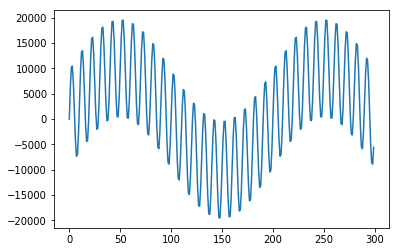

In [275]:
plt.plot(f)

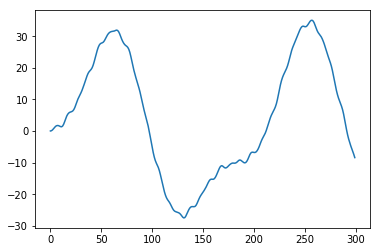

In [276]:
plt.plot(r_end)

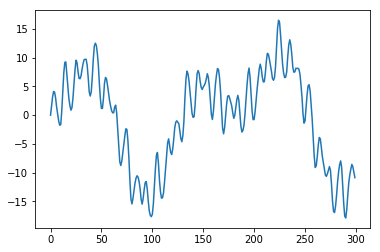

In [277]:
plt.plot(rt_end)


In [278]:
#Training data

d = 10 #number of steps in "model memory"
t = d

X_train = np.zeros([d*3+1, n_timesteps-d])
Y_train = np.zeros([2, n_timesteps-d])

for i in range(n_timesteps-d):
    X_train[0:d+1,i] = np.array(f[t-d:t+1])*1/10000
    X_train[d+1:2*d+1,i] = r_end[t-d:t]
    X_train[(2*d+1):,i] = np.array(rt_end[t-d:t])
    
    Y_train[:, i] = [r_end[t], rt_end[t]]
    t += 1


In [279]:
X_train[:,0]

array([ 0.        ,  0.61919601,  1.01384704,  1.04516483,  0.71311849,
        0.15643447, -0.40040394, -0.73291327, -0.70236663, -0.30879415,
        0.30901699,  0.        ,  0.08269142,  0.32447595,  0.68963147,
        1.0947492 ,  1.44139632,  1.65782661,  1.73215057,  1.68669137,
        1.54825013,  0.        ,  1.65382845,  3.18186214,  4.12124822,
        3.98110631,  2.95183622,  1.37676961,  0.10970943, -1.01889325,
       -1.74993174])

In [280]:
#Neural network

train_portion = 0.8
input_dim = len(X_train[:,0])

x_train = X_train[:,0:int(n_timesteps*train_portion)]
x_test = X_train[:,int(n_timesteps*(1-train_portion)):]
y_train = Y_train[:,0:int(n_timesteps*train_portion)]
y_test = Y_train[:,int(n_timesteps*(1-train_portion)):]

def baseline_model():
    model = Sequential()
    height = 50
    model.add(Dense(height, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
    #model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(2, input_dim=height, activation='linear', kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer="adam")
    return model



# Training the model
model = baseline_model()
model.fit(np.transpose(x_train), np.transpose(y_train), epochs=500, verbose = 0)

In [281]:
predictions = model.predict(np.transpose(x_test))

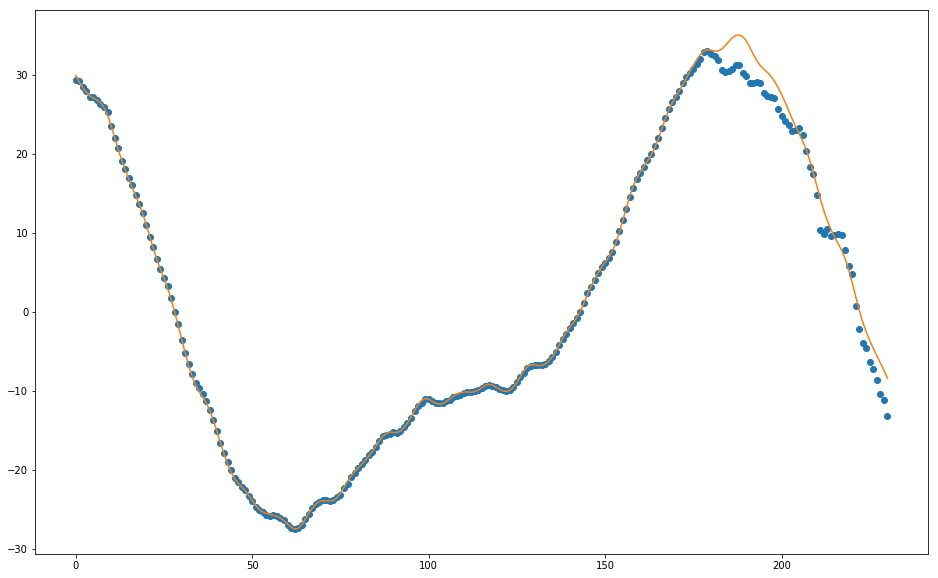

In [282]:
plt.figure(figsize=(16,10))
plt.plot(predictions[:,0], 'o')
plt.plot(y_test[0,:])
plt.show()

In [309]:
#independent prediction

input_i = x_test[:,0]
r = input_i[d+1:2*d+1]
rt = input_i[2*d+1:]

predictions = []
force = x_test[0:d+1,:]
for i in range(200):
    
    
    pred = model.predict(np.reshape(input0,(1,len(input_i))))
    predictions.append(pred[0][0])
    
    input_i[0:d+1] = force[:, i+1]
    
    r = np.delete(r, -1)
    r = np.insert(r, 0, pred[0][0])
    rt = np.delete(rt, -1)
    rt = np.insert(rt, 0, pred[0][1])
    input_i[d+1:2*d+1] = r
    input_i[2*d+1:] = rt
    

In [310]:
pred

array([[-26.40389061,  -6.28555918]], dtype=float32)

In [311]:
print(input_i)
input_i=np.delete(input_i, -1)
print(input_i)

[  0.37250843   0.95105652   1.52866602   1.880833     1.86881114
   1.4926123    0.89100652   0.28852143  -0.09031449  -0.10672859
   0.23929532 -26.40389061 -23.79377556 -23.88964081 -23.15517616
 -22.66425323 -22.69579315 -22.97463036 -25.58445358 -25.16144371
 -25.51892853  -6.28555918 -11.13791943 -11.76415539  -9.95849609
  -1.10582232   5.22375488   6.11340141   2.44467735  -2.26660991
  -4.83410835]
[  0.37250843   0.95105652   1.52866602   1.880833     1.86881114
   1.4926123    0.89100652   0.28852143  -0.09031449  -0.10672859
   0.23929532 -26.40389061 -23.79377556 -23.88964081 -23.15517616
 -22.66425323 -22.69579315 -22.97463036 -25.58445358 -25.16144371
 -25.51892853  -6.28555918 -11.13791943 -11.76415539  -9.95849609
  -1.10582232   5.22375488   6.11340141   2.44467735  -2.26660991]


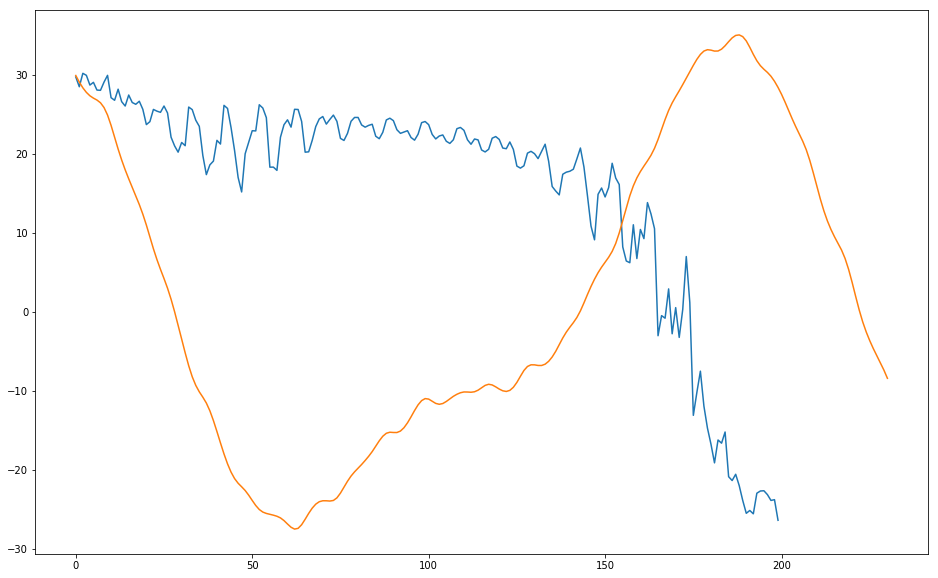

In [315]:
plt.figure(figsize=(16,10))
plt.plot(predictions)
plt.plot(y_test[0,:])
plt.show()